В базе данных нефтегазовых месторождений одной компании произошёл системный сбой и информация о типе месторождения по расположению (на берегу или в открытом море) была удалена. Так как эта информация крайне важна, вам необходимо восстановить её в пострадавшем датасете

Входные данные: тренировочный датасет train.csv, в котором поля обозначают следующее:

Tectonic regime – тектонический режим месторождения  
Onshore/Oﬀshore – тип месторождения по расположению  
Hydrocarbon type – тип углеводородов  
Reservoir status – статус разработки месторождения  
Structural setting – структурные особенности месторождения  
Depth – средняя глубина кровли резервуара  
Period – геологическая система образования резервуара  
Lithology – основной литологический состав коллектора  
Gross – среднее значение общей толщины резервуара  
Netpay – среднее значение эффективной углеводородонасыщенной толщины коллектора  
Porosity – среднее значение матричной пористости  
Permeability – среднее значение проницаемости по воздуху.  

test.csv – датасет, для которого необходимо предсказать поле «Onshore/Oﬀshore»

Выходные данные: файл prediction.csv, в котором одна колонка (без заголовка) с предсказанием поля Onshore/Oﬀshore. Предсказания следует выводить в тех же значениях, в каких они представлены в тренировочном датасете (ONSHORE/OFFSHORE/ ONSHORE-OFFSHORE).

Критерии проверки: вычисляется точность предсказания (accuracy_score), округляется до 2-х знаков и итоговый балл считается по формуле score = 50*accuracy_score. Таким образом максимальный балл 50 будет соответствовать максимально точности 1.

In [ ]:
# https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Data proccessing

In [103]:
train_df = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")

train_df.columns = train_df.columns.str.replace('\s+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('\s+', '_', regex=True)

In [54]:
# looks on target distribution
train_df['Onshore/Offshore'].value_counts()

ONSHORE             211
OFFSHORE             93
ONSHORE-OFFSHORE      5
Name: Onshore/Offshore, dtype: int64

In [104]:
# Process traget
train_df.replace({"OFFSHORE": 0,
                   "ONSHORE": 1,
                  "ONSHORE-OFFSHORE":2
                        }, inplace=True)

In [105]:
# Look on most minorital class
train_df[(train_df["Onshore/Offshore"] == 2)]

,Tectonic_regime,Onshore/Offshore,Hydrocarbon_type,Reservoir_status,Structural_setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
49,COMPRESSION/EROSION,2,OIL,MATURE PRODUCTION,WRENCH/FORELAND,1400,NEOGENE,SANDSTONE,500.0,120.0,35.0,1200.0
110,COMPRESSION/EROSION,2,OIL,NEARLY DEPLETED,FORELAND,6550,CRETACEOUS,DOLOMITE,1300.0,200.0,11.0,10.0
194,STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,2,OIL,NEARLY DEPLETED,WRENCH,2326,NEOGENE,THINLY-BEDDED SANDSTONE,700.0,375.0,28.0,400.0
195,STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,2,OIL,NEARLY DEPLETED,WRENCH,1726,NEOGENE,THINLY-BEDDED SANDSTONE,660.0,152.0,34.0,2300.0
228,INVERSION/COMPRESSION/EXTENSION,2,OIL,DECLINING PRODUCTION,RIFT/INVERSION,4954,TRIASSIC,SANDSTONE,525.0,150.0,18.0,100.0


In [106]:
# Drop last class
train_df = train_df[(train_df["Onshore/Offshore"] == 0) |
                    (train_df["Onshore/Offshore"] == 1)].reset_index(drop=True)

In [57]:
test_profile = ProfileReport(X_test)
test_profile.to_file("reports/test_data.html")

In [ ]:
train_profile = ProfileReport(train_df)
train_profile.to_file("reports/train_data.html")

In [107]:
num_cols = ["Depth", "Gross", "Netpay", "Porosity", "Permeability"]
cat_cols = ["Tectonic_regime", "Hydrocarbon_type", "Reservoir_status", "Structural_setting", "Period", "Lithology"]
feature_cols = num_cols + cat_cols
target_col = "Onshore/Offshore"

In [108]:
X = pd.concat([train_df[num_cols],
               pd.get_dummies(train_df[cat_cols], drop_first=True)],
              axis=1)
Y = train_df[target_col]

In [109]:
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  train_size=0.8,
                                                  random_state=42)

In [110]:
# Scale data
my_scaler = MinMaxScaler()
X_train[num_cols] = pd.DataFrame(my_scaler.fit_transform(X_train[num_cols]),
                                 columns=num_cols, index=X_train.index)
X_val[num_cols] = pd.DataFrame(my_scaler.transform(X_val[num_cols]),
                               columns=num_cols, index=X_val.index)

In [111]:
y_train.value_counts()

1    170
0     73
Name: Onshore/Offshore, dtype: int64

In [112]:
y_val.value_counts()

1    41
0    20
Name: Onshore/Offshore, dtype: int64

# Models training

In [199]:
from sklearn.linear_model import LogisticRegressionCV
from gplearn.genetic import SymbolicClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import keras

In [19]:
# Oversampling

# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
# sm = RandomOverSampler(random_state=42,
#                        sampling_strategy={1:180,0:78, 2:30}
#                       )
# und = RandomUnderSampler(random_state=42,
#                        sampling_strategy={1:180,0:78, 2:30}
#                       )
#
# X_train, y_train = sm.fit_resample(X_train, y_train)
# X_train, y_train = und.fit_resample(X_train, y_train)

In [20]:
# For multiclass prediction

# def metrics_eval(model, X_test, y_test):
#     from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
#     y_pred = pd.DataFrame(model.predict_proba(X_test).round(3).argmax(axis=1), columns=['target_pred'])
#     print('Max test auc_roc:', roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr"))
#     print('Max test accuracy_score:', accuracy_score(y_test, y_pred))
#     print('classification_report:\n', classification_report(y_test, y_pred))
#     df = pd.DataFrame(confusion_matrix(y_test, y_pred))
#     sns.heatmap(df, annot=True, cbar=None, cmap="Blues")

In [181]:
models_dict = {'Model_name': [],
               'model': [],
               'threshold':[],
               'val_accuracy': [],
               }

def opt_threshold_acc(y_true, y_pred):
    A = list(zip(y_true, y_pred))
    A = sorted(A, key=lambda x: x[1])
    total = len(A)
    tp = len([1 for x in A if x[0]==1])
    tn = 0
    th_acc = []
    for x in A:
        th = x[1]
        if x[0] == 1:
            tp -= 1
        else:
            tn += 1
        acc = (tp + tn) / total
        th_acc.append((th, acc))
    return max(th_acc, key=lambda x: x[1])

def metric_eval(y_pred, y_test , rate):
    y_pred = pd.Series(y_pred).apply(lambda x: 1 if x > rate else 0)
    print('Max test accuracy_score:', accuracy_score(y_test, y_pred))
    print('classification_report:\n', classification_report(y_test, y_pred))
    df = pd.DataFrame(confusion_matrix(y_test, y_pred))
    sns.heatmap(df, annot=True, cbar=None, cmap="Blues")

def seve_best_model(models_dict, model, y_val, y_pred):
    threshold, accuracy = opt_threshold_acc(y_val, y_pred)

    models_dict['Model_name'].append(model.__class__.__name__)
    models_dict['model'].append(model)
    models_dict['threshold'].append(threshold)
    models_dict['val_accuracy'].append(accuracy)

    metric_eval(y_pred, y_val, rate=threshold)

### SymbolicClassifier

In [114]:
est_gp = SymbolicClassifier(population_size=5000,
                           function_set=('add', 'sub', 'mul','div','sin','cos','tan','log','sqrt'),
                           generations=40, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.15         0.727579        3         0.572455         0.557255      4.86m
   1     2.81         0.633395        3         0.558086         0.682552      3.65m
   2     2.43         0.627524        5         0.530215         0.715995      3.65m
   3     2.79         0.603442        5          0.52502         0.761292      3.44m
   4     3.41          0.58504        6         0.510169         0.849587      3.47m
   5     3.80         0.582695       10         0.499215         0.765191      3.66m
   6     4.47         0.571671       10         0.489476         0.850122      4.14m
   7     4.69         0.566652       10         0.493909         0.811466      3.57m
   8     4.70         0.569645       10         0.488635         0.857453  

SymbolicClassifier(function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos',
                                 'tan', 'log', 'sqrt'),
                   generations=40, max_samples=0.9, p_crossover=0.7,
                   p_hoist_mutation=0.05, p_point_mutation=0.1,
                   p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                   population_size=5000, random_state=0, stopping_criteria=0.01,
                   verbose=1)

Max test accuracy_score: 0.6885245901639344
classification_report:
               precision    recall  f1-score   support

           0       0.52      0.65      0.58        20
           1       0.81      0.71      0.75        41

    accuracy                           0.69        61
   macro avg       0.66      0.68      0.67        61
weighted avg       0.71      0.69      0.70        61



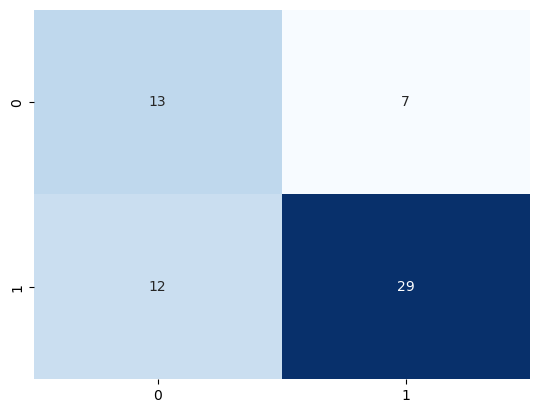

In [182]:
y_pred = est_gp.predict_proba(X_val)[:, 1]
seve_best_model(models_dict, est_gp, y_val, y_pred)

### XGBClassifier

In [125]:
# For multiclass prediction

#xgb_model = xgb.XGBRegressor(objective="multi:softmax",num_class=3, random_state=42) # squarederror
#
# params = {
#     "colsample_bytree": [0.7, 0.3],
#     "gamma": [0, 0.5],
#     "learning_rate": [0.1, 0.03, 0.3], # default 0.1
#     "max_depth": [2, 6], # default 3
#     "n_estimators": [100, 300], # default 100
#     "subsample": [0.6, 0.4]
# }
#
# search = GridSearchCV(xgb_model,
#                     param_grid=params,
#                     cv=3,
#                     verbose=1,
#                   n_jobs=-1)
# search.fit(X_train, y_train)

In [186]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

params = {
    "colsample_bytree": [0.7, 0.3],
    "gamma": [0, 0.5],
    "learning_rate": [0.03, 0.3], # default 0.1 
    "max_depth": [2, 6], # default 3
    "n_estimators": [100, 300], # default 100
    "subsample": [0.6, 0.4]
}

search_xgb = GridSearchCV(xgb_model,
                    param_grid=params,
                    cv=3,
                    verbose=1,
                  n_jobs=-1)
search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.3], 'gamma': [0, 0.5],
                         'learning_rate': [0.03, 0.3], 'max_depth': [2, 6],
                         'n_estimators': [100, 300], 'subsample': [0.6, 0.4]},
             verbose=1)

Max test accuracy_score: 0.8852459016393442
classification_report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84        20
           1       0.95      0.88      0.91        41

    accuracy                           0.89        61
   macro avg       0.86      0.89      0.87        61
weighted avg       0.89      0.89      0.89        61



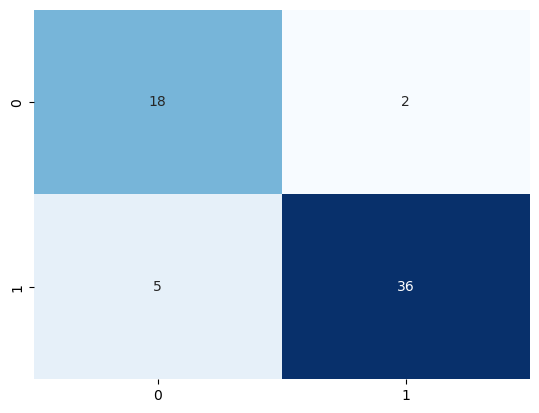

In [187]:
y_pred = search_xgb.best_estimator_.predict_proba(X_val)[:, 1]
seve_best_model(models_dict, search_xgb.best_estimator_, y_val, y_pred)

### LogisticRegressionCV

In [188]:
# Обучение модели Логистической регрессии
fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

logit_reg = LogisticRegressionCV(
    penalty="l2",
    scoring='accuracy', # aug_score, recall_weighted, accuracy
    Cs=list(np.power(10.0, np.arange(-10, 10))),
    n_jobs=-1,
    max_iter=15000,
    cv=fold,
    refit=True,
#     class_weight="balanced",
#     tol=0.0002,
    random_state=42,
    multi_class = "ovr" # multinomial or ovr
    )
logit_reg.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                         0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                         100000.0, 1000000.0, 10000000.0, 100000000.0,
                         1000000000.0],
                     cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                     max_iter=15000, multi_class='ovr', n_jobs=-1,
                     random_state=42, scoring='accuracy')

Max test accuracy_score: 0.8360655737704918
classification_report:
               precision    recall  f1-score   support

           0       0.86      0.60      0.71        20
           1       0.83      0.95      0.89        41

    accuracy                           0.84        61
   macro avg       0.84      0.78      0.80        61
weighted avg       0.84      0.84      0.83        61



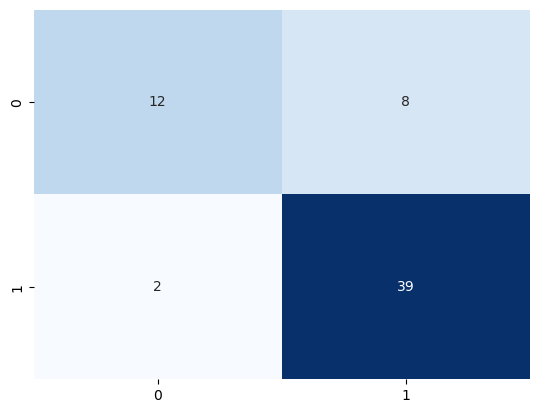

In [189]:
y_pred = logit_reg.predict_proba(X_val)[:, 1]
seve_best_model(models_dict, logit_reg, y_val, y_pred)

In [129]:
# import pickle
# with open("models/log_reg.pickle", "wb") as record_file:
#     record_file = pickle.dumps(logit_reg)

In [73]:
# import pickle
# with open("models/log_reg.pickle", "rb") as read_file:
#     best_log_reg = pickle.load(read_file)
# metrics_eval(best_log_reg, X_test, y_test)

### Neural network

In [190]:
# Обучение нейронной сети
my_callbacks = [keras.callbacks.EarlyStopping(patience=20),
                keras.callbacks.ModelCheckpoint(
                    filepath='models/best_model.h5',
                    monitor='val_accuracy',
                    save_weights_only=True,
                    mode='max',
                    save_best_only=True)
]

nn_model = keras.Sequential([
    keras.layers.Dense(30, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', #adam rmsprop
#               loss="categorical_crossentropy",
                 loss="binary_crossentropy",
              metrics=["accuracy"],)

nn_model.fit(X_train, y_train,
             epochs=100,
             validation_data=(X_val, y_val),
             verbose=1,
             callbacks=my_callbacks,
#              class_weight={0:3, 1:2, 2:16}
            class_weight={0:3, 1:2}
            )

nn_model.load_weights("best_model.h5")

Epoch 1/100
8/8 [==============================] - 4s 81ms/step - loss: 1.5322 - accuracy: 0.6996 - val_loss: 0.6373 - val_accuracy: 0.7049
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 1.4642 - accuracy: 0.7078 - val_loss: 0.6072 - val_accuracy: 0.6885
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 1.3958 - accuracy: 0.7531 - val_loss: 0.5811 - val_accuracy: 0.7049
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 1.3244 - accuracy: 0.7737 - val_loss: 0.5517 - val_accuracy: 0.7213
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 1.2405 - accuracy: 0.8066 - val_loss: 0.5240 - val_accuracy: 0.7213
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 1.1578 - accuracy: 0.8189 - val_loss: 0.4981 - val_accuracy: 0.7705
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 1.0672 - accuracy: 0.8395 - val_loss: 0.4768 - val_accuracy: 0.7869
Epoch 8/100
8/8 [===

2/2 [==============================] - 0s 6ms/step
Max test accuracy_score: 0.9672131147540983
classification_report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.98      0.98      0.98        41

    accuracy                           0.97        61
   macro avg       0.96      0.96      0.96        61
weighted avg       0.97      0.97      0.97        61



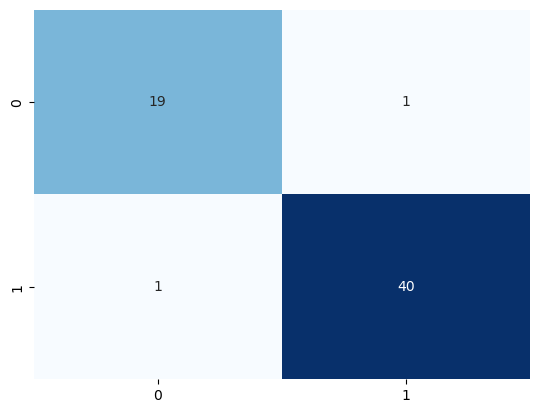

In [191]:
y_pred = nn_model.predict(X_val).flatten()
seve_best_model(models_dict, nn_model, y_val, y_pred)

### RandomForestClassifier

In [192]:
rf_params = {
        "max_depth": [None],
        "max_features": [1],
        "min_samples_split": [2, 3, 10],
        "min_samples_leaf": [1, 3, 10],
        "bootstrap": [False],
        "n_estimators": [300],
        "criterion": ["gini","entropy"],
        "class_weight":["balanced"]
    }

kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
random_forest_model = GridSearchCV(RandomForestClassifier(),
                    param_grid=rf_params,
                    cv=kfold,
                    n_jobs=-1,
                    scoring="accuracy", # accuracy
                    verbose=1,
                    )

random_forest_model.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'], 'max_depth': [None],
                         'max_features': [1], 'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [300]},
             scoring='accuracy', verbose=1)

Max test accuracy_score: 0.8688524590163934
classification_report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.92      0.88      0.90        41

    accuracy                           0.87        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.87      0.87      0.87        61



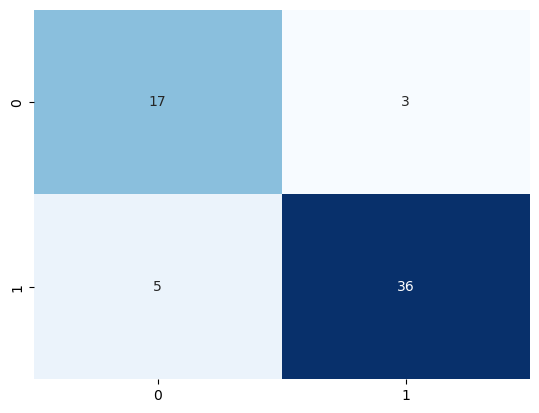

In [193]:
y_pred = random_forest_model.best_estimator_.predict_proba(X_val)[:, 1]
seve_best_model(models_dict, random_forest_model, y_val, y_pred)

### GradientBoostingClassifier

In [38]:
gb_params = {
        'loss' : ["log_loss"],
        'n_estimators' : [100, 200, 300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 8],
        'min_samples_leaf': [100, 150],
        'max_features': [0.3, 0.1]}

kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
gb_model = GridSearchCV(GradientBoostingClassifier(),
                    param_grid=gb_params,
                    cv=kfold,
                    n_jobs=-1,
                    scoring="accuracy",
                    verbose=1,
                    )

gb_model.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'loss': ['log_loss'], 'max_depth': [4, 8],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

Max test accuracy_score: 0.8688524590163934
classification_report:
               precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.88      0.93      0.90        41

    accuracy                           0.87        61
   macro avg       0.86      0.84      0.85        61
weighted avg       0.87      0.87      0.87        61



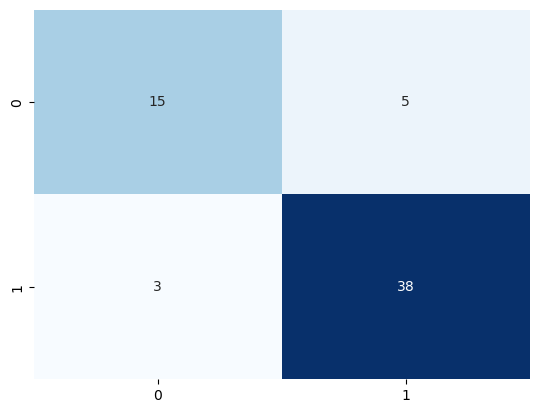

In [194]:
y_pred = gb_model.best_estimator_.predict_proba(X_val)[:, 1]
seve_best_model(models_dict, gb_model.best_estimator_, y_val, y_pred)

### MLPClassifier

In [196]:
mlp_params = {
        'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), 100],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [400],
        'early_stopping': [True]}

kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
mlp_model = GridSearchCV(MLPClassifier(),
                    param_grid=mlp_params,
                    cv=kfold,
                    n_jobs=-1,
                    scoring="accuracy",
                    verbose=1,
                    )
mlp_model.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/anaconda3/envs/yandex_я_проф/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/yandex_я_проф/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/yandex_я_проф/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/yandex_я_проф/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/yandex_я_проф/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaco

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05], 'early_stopping': [True],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                100],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [400], 'solver': ['sgd', 'adam']},
             scoring='accuracy', verbose=1)

Max test accuracy_score: 0.7213114754098361
classification_report:
               precision    recall  f1-score   support

           0       1.00      0.15      0.26        20
           1       0.71      1.00      0.83        41

    accuracy                           0.72        61
   macro avg       0.85      0.57      0.54        61
weighted avg       0.80      0.72      0.64        61



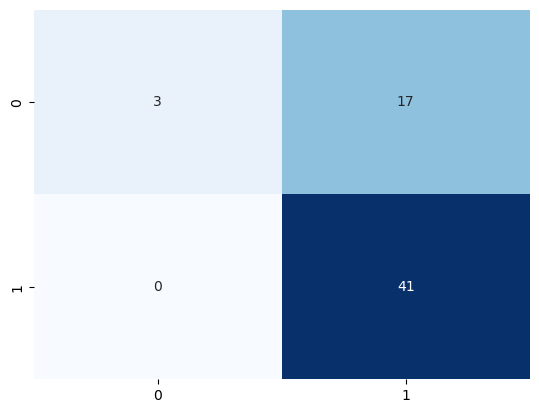

In [197]:
y_pred = mlp_model.best_estimator_.predict_proba(X_val)[:, 1]
seve_best_model(models_dict, mlp_model.best_estimator_, y_val, y_pred)

### VotingClassifier

In [201]:
voting = VotingClassifier(estimators=[("logit", logit_reg),
                                      ("xgb", xgb_model),
                                      ("randomforest", random_forest_model.best_estimator_)],
                          voting='soft', n_jobs=-1)
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('logit',
                              LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08,
                                                       1e-07, 1e-06, 1e-05,
                                                       0.0001, 0.001, 0.01, 0.1,
                                                       1.0, 10.0, 100.0, 1000.0,
                                                       10000.0, 100000.0,
                                                       1000000.0, 10000000.0,
                                                       100000000.0,
                                                       1000000000.0],
                                                   cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                                                   max_iter=15000,
                                                   multi_class='ovr', n_jobs=-1,
                                                   random_state=42,
                                                   scoring='accuracy')),
                             ('x...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('randomforest',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight='balanced',
                                                     max_features=1,
                                                     min_samples_split=3,
                                                     n_estimators=300))],
                 n_jobs=-1, voting='soft')

Max test accuracy_score: 0.8852459016393442
classification_report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84        20
           1       0.95      0.88      0.91        41

    accuracy                           0.89        61
   macro avg       0.86      0.89      0.87        61
weighted avg       0.89      0.89      0.89        61



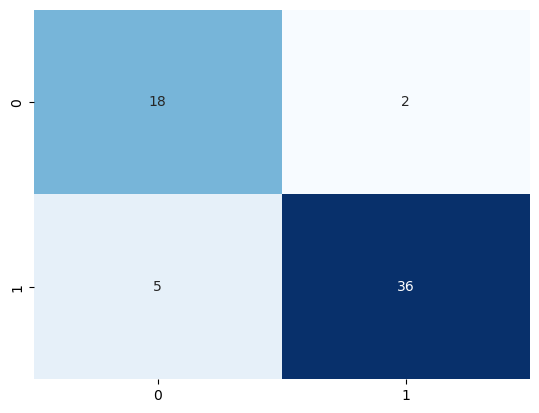

In [202]:
y_pred = voting.predict_proba(X_val)[:, 1]
seve_best_model(models_dict, voting, y_val, y_pred)

# Write best model prediction to file

In [218]:
models_df = pd.DataFrame(models_dict).sort_values('val_accuracy')
models_df

,Model_name,model,threshold,val_accuracy
0,SymbolicClassifier,"add(X81, add(add(cos(X151), X81), X81))",0.631883,0.721311
6,MLPClassifier,"MLPClassifier(activation='tanh', alpha=0.05, early_stopping=True,\n hidden_layer_sizes=100, max_iter=400)",0.477549,0.721311
2,LogisticRegressionCV,"LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,\n 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,\n 100000.0, 100000...",0.451666,0.836066
4,GridSearchCV,"GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),\n estimator=RandomForestClassifier(), n_jobs=-1,\n param_grid={'bootstrap': [False], 'class_weig...",0.635943,0.868852
5,GradientBoostingClassifier,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=4, max_features=0.3,\n min_samples_leaf=100,\n random_state=RandomState(MT19937) at 0x7FBECF2A...",0.518333,0.868852
1,XGBClassifier,"XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,\n early_stopping_rounds=None, enable_cate...",0.658587,0.885246
7,VotingClassifier,"VotingClassifier(estimators=[('logit',\n LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08,\n 1e-07, 1e-06, 1e-05,\n ...",0.619100,0.885246
3,Sequential,<keras.engine.sequential.Sequential object at 0x7fbea2690eb0>,0.296236,0.967213


In [205]:
std_num_data = pd.DataFrame(my_scaler.transform(X_test[num_cols]),
                            columns=X_test[num_cols].columns)
enc_cat_data = pd.get_dummies(X_test[cat_cols], drop_first=True)
preccesed_data_test = pd.concat([std_num_data, enc_cat_data], axis=1)
preccesed_data_test = preccesed_data_test.reindex(columns =X.columns, fill_value=0)

preccesed_data_test

,Depth,Gross,Netpay,Porosity,Permeability,Tectonic_regime_COMPRESSION/EROSION,Tectonic_regime_COMPRESSION/EROSION/EXTENSION,Tectonic_regime_COMPRESSION/EROSION/EXTENSION/LINKED,Tectonic_regime_COMPRESSION/EROSION/GRAVITY/EVAPORITE/EXTENSION,Tectonic_regime_COMPRESSION/EVAPORITE,Tectonic_regime_COMPRESSION/EVAPORITE/EXTENSION/LINKED,Tectonic_regime_COMPRESSION/EVAPORITE/GRAVITY,Tectonic_regime_COMPRESSION/EXTENSION/EROSION,Tectonic_regime_COMPRESSION/EXTENSION/EROSION/EVAPORITE,Tectonic_regime_COMPRESSION/EXTENSION/EVAPORITE,Tectonic_regime_COMPRESSION/EXTENSION/LINKED,Tectonic_regime_COMPRESSION/EXTENSION/LINKED/EROSION,Tectonic_regime_COMPRESSION/GRAVITY/EVAPORITE/EXTENSION/LINKED,Tectonic_regime_COMPRESSION/SHALE,Tectonic_regime_COMPRESSION/SHALE/REACTIVATION/BASEMENT-I,Tectonic_regime_COMPRESSION/STRIKE-SLIP/BASEMENT-I,Tectonic_regime_COMPRESSION/STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,Tectonic_regime_COMPRESSION/STRIKE-SLIP/TRANSPRESSION/SHALE/BASEMENT-I,Tectonic_regime_EVAPORITE/INVERSION/COMPRESSION/EXTENSION,Tectonic_regime_EXTENSION,Tectonic_regime_EXTENSION/COMPRESSION,Tectonic_regime_EXTENSION/EROSION,Tectonic_regime_EXTENSION/EROSION/GRAVITY/EVAPORITE,Tectonic_regime_EXTENSION/EVAPORITE,Tectonic_regime_EXTENSION/EVAPORITE/EROSION/GRAVITY,Tectonic_regime_EXTENSION/EVAPORITE/GRAVITY,Tectonic_regime_EXTENSION/EVAPORITE/INVERSION,Tectonic_regime_EXTENSION/INVERSION,Tectonic_regime_GRAVITY/COMPRESSION/SHALE/EXTENSION/LINKED,Tectonic_regime_GRAVITY/EVAPORITE/COMPRESSION,Tectonic_regime_GRAVITY/EVAPORITE/COMPRESSION/EXTENSION,Tectonic_regime_GRAVITY/EVAPORITE/EXTENSION,Tectonic_regime_GRAVITY/EXTENSION/EVAPORITE,Tectonic_regime_GRAVITY/EXTENSION/EVAPORITE/DIAPIR,Tectonic_regime_GRAVITY/EXTENSION/EVAPORITE/DIAPIR/SYNSEDIMENTATION,Tectonic_regime_GRAVITY/EXTENSION/EVAPORITE/SYNSEDIMENTATION,Tectonic_regime_GRAVITY/EXTENSION/SHALE,Tectonic_regime_GRAVITY/EXTENSION/SHALE/SYNSEDIMENTATION,Tectonic_regime_GRAVITY/SHALE/EXTENSION,Tectonic_regime_GRAVITY/SHALE/EXTENSION/SYNSEDIMENTATION,Tectonic_regime_INVERSION/COMPRESSION/EXTENSION,Tectonic_regime_INVERSION/COMPRESSION/EXTENSION/EROSION,Tectonic_regime_INVERSION/COMPRESSION/EXTENSION/EVAPORITE,Tectonic_regime_INVERSION/COMPRESSION/EXTENSION/EVAPORITE/GRAVITY,Tectonic_regime_INVERSION/COMPRESSION/EXTENSION/SHALE,Tectonic_regime_INVERSION/EXTENSION/COMPRESSION,Tectonic_regime_INVERSION/STRIKE-SLIP/TRANSPRESSION/EXTENSION/BASEMENT-I,Tectonic_regime_STRIKE-SLIP/BASEMENT-I,Tectonic_regime_STRIKE-SLIP/INVERSION/COMPRESSION/EXTENSION,Tectonic_regime_STRIKE-SLIP/TRANSPRESSION,Tectonic_regime_STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,Tectonic_regime_STRIKE-SLIP/TRANSTENSION/SHALE/EVAPORITE/BASEMENT-I,Tectonic_regime_TRANSPRESSION/UPLIFT,Tectonic_regime_TRANSTENSION/EXTENSION/SHALE/LINKED,Tectonic_regime_UPLIFT/BASEMENT-I,Hydrocarbon_type_GAS,Hydrocarbon_type_GAS-CONDENSATE,Hydrocarbon_type_METHANE HYDRATE,Hydrocarbon_type_OIL,Reservoir_status_CONTINUING DEVELOPMENT,Reservoir_status_DECLINING PRODUCTION,Reservoir_status_DEPLETED,Reservoir_status_DEVELOPING,Reservoir_status_MATURE PRODUCTION,Reservoir_status_NEARLY DEPLETED,Reservoir_status_PLATEAU PRODUCTION,Reservoir_status_REJUVENATING,Reservoir_status_SECOND PLATEAU PRODUTION,Reservoir_status_UNDEVELOPED,Reservoir_status_UNKNOWN,Structural_setting_DELTA//FORELAND,Structural_setting_DELTA/FORELAND,Structural_setting_DELTA/PASSIVE MARGIN,Structural_setting_DELTA/SALT/PASSIVE MARGIN,Structural_setting_DELTA/SUB-SALT/PASSIVE MARGIN,Structural_setting_DELTA/WRENCH,Structural_setting_FORELAND,Structural_setting_FORELAND/PASSIVE MARGIN,Structural_setting_FORELAND/SALT,Structural_setting_FORELAND/THRUST,Structural_setting_FORELAND/WRENCH,Structural_setting_INTRACRATONIC,Structural_setting_INTRACRATONIC/SUB-SALT,Structural_setting_INVERSION/BACKARC,Structural_setting_INVERSION/FOREARC,Structural_setting_INVERSION/FORELAND,Structural_setting_INVERSION/RIFT,Structural_setting_INVERSION/SALT/RIFT,Structural_setting_INVERSION/WRENCH,Structural_setting_PASS

In [217]:
nn_model = models_df.iloc[-1]['model']
res_df_nn = pd.DataFrame((nn_model.predict(preccesed_data_test) > models_df.iloc[-1]['threshold']) * 1)\
            .replace({0: "OFFSHORE", 1:"ONSHORE", 2:"ONSHORE-OFFSHORE"})
res_df_nn.to_csv("outputs/prediction__.csv", header=False, index=False)

5/5 [==============================] - 0s 2ms/step
